<span style='font-size:xx-large'>Logistic Regression</span>



In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
from modeling_data import Data_Import
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
%matplotlib inline

# Initialize progress bars for pandas
tqdm.pandas()

In [3]:
# Load cleaned dataset
data = Data_Import()

## Solver Choice

I chose the "lbfgs" solver because it is ideal for a problem with many variables due to storing a limited version of the inverse hessian matrix; it can solve our high\-dimension problem quickly



## Hyperparameter Tuning

I will now iterate over C values and graph them to determine a C value. The C value is the inverse of regularization strength.



In [4]:
# Determine optimal values for C
logreg_c_test_accs = []
logreg_c_train_accs = []
allcs = [10, 5, 1, 1/10,1/100,1/1000,1/10000]
for C in tqdm(allcs):
    logreg = LogisticRegression(random_state=42, multi_class='ovr', solver='lbfgs', C=C, max_iter=1000, n_jobs=-4)
    logreg_fit = logreg.fit(data.X_train, data.y_train)
    y_pred = logreg_fit.predict(data.X_test)
    y_pred_train = logreg_fit.predict(data.X_train)
    logreg_c_test_accs.append(accuracy_score(data.y_test,y_pred))
    logreg_c_train_accs.append(accuracy_score(data.y_train,y_pred_train))

  0%|          | 0/7 [00:00<?, ?it/s]

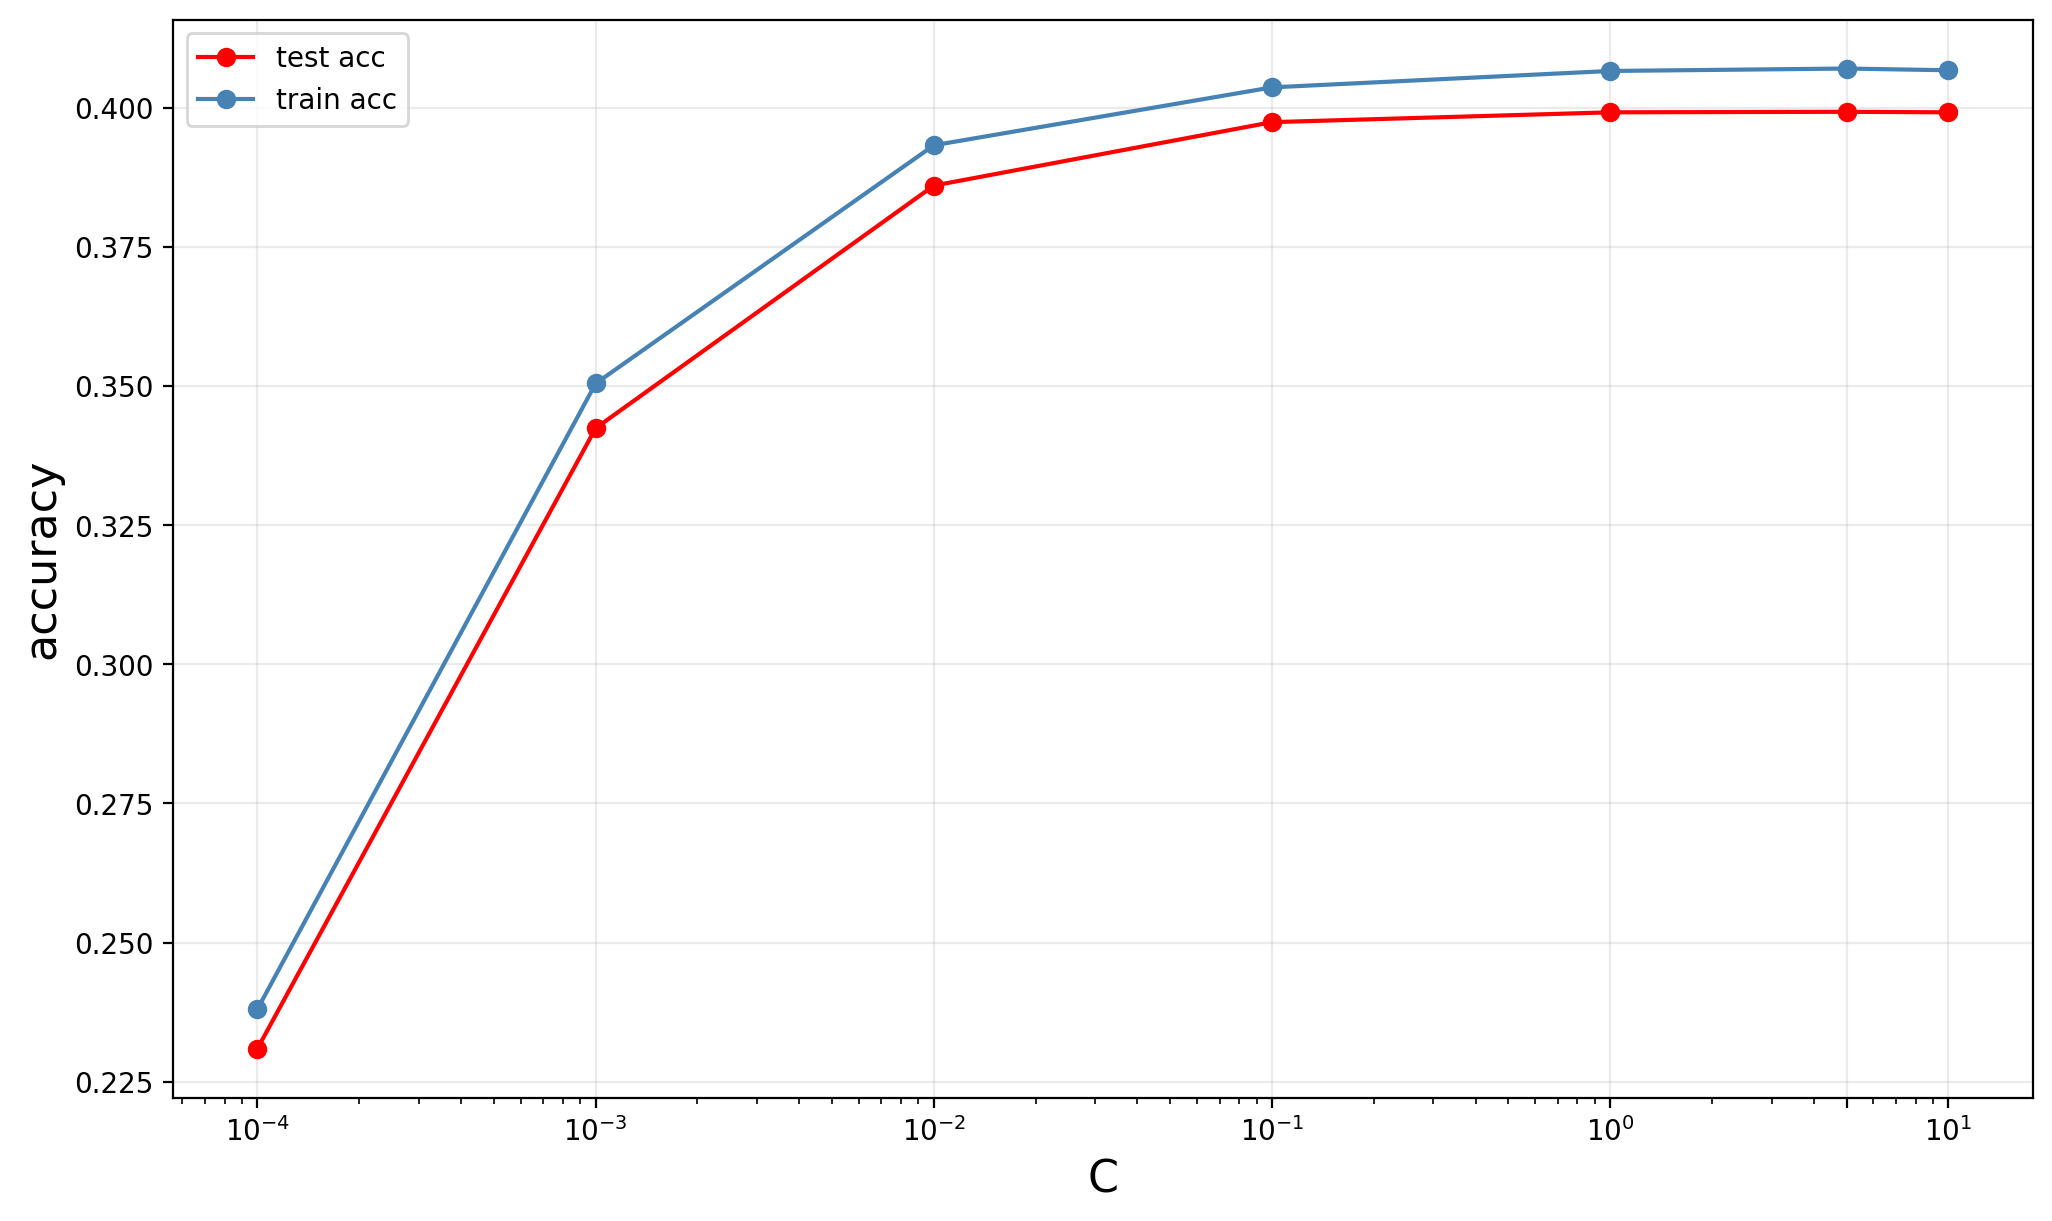

In [5]:
# Plot the C results
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,7))
ax.plot(allcs, logreg_c_test_accs, marker="o", color="red", label="test acc")
ax.plot(allcs, logreg_c_train_accs, marker="o", color="steelblue", label="train acc")
ax.set_xlabel("C", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.legend()
plt.xscale("log")
plt.xticks(allcs)
ax.grid(alpha=0.25)

It looks like the test and training accuracies are very close, which means the model is probably not overfitting. I will choose 1 as the C value because higher values do not continue to increase the accuracy significantly.


In [6]:
best_C = 1

In [7]:
# Model based on best C value
logreg = LogisticRegression(random_state=42, multi_class='ovr', solver='lbfgs', C=best_C, max_iter=1000, n_jobs=-4)
logreg_fit = logreg.fit(data.X_train, data.y_train)
y_pred = logreg_fit.predict(data.X_test)
print(accuracy_score(data.y_test,y_pred))

0.3991627906976744


## Analysis

Now that I have determined that the best model uses C=1, I will create some visualizations to help with analysis.



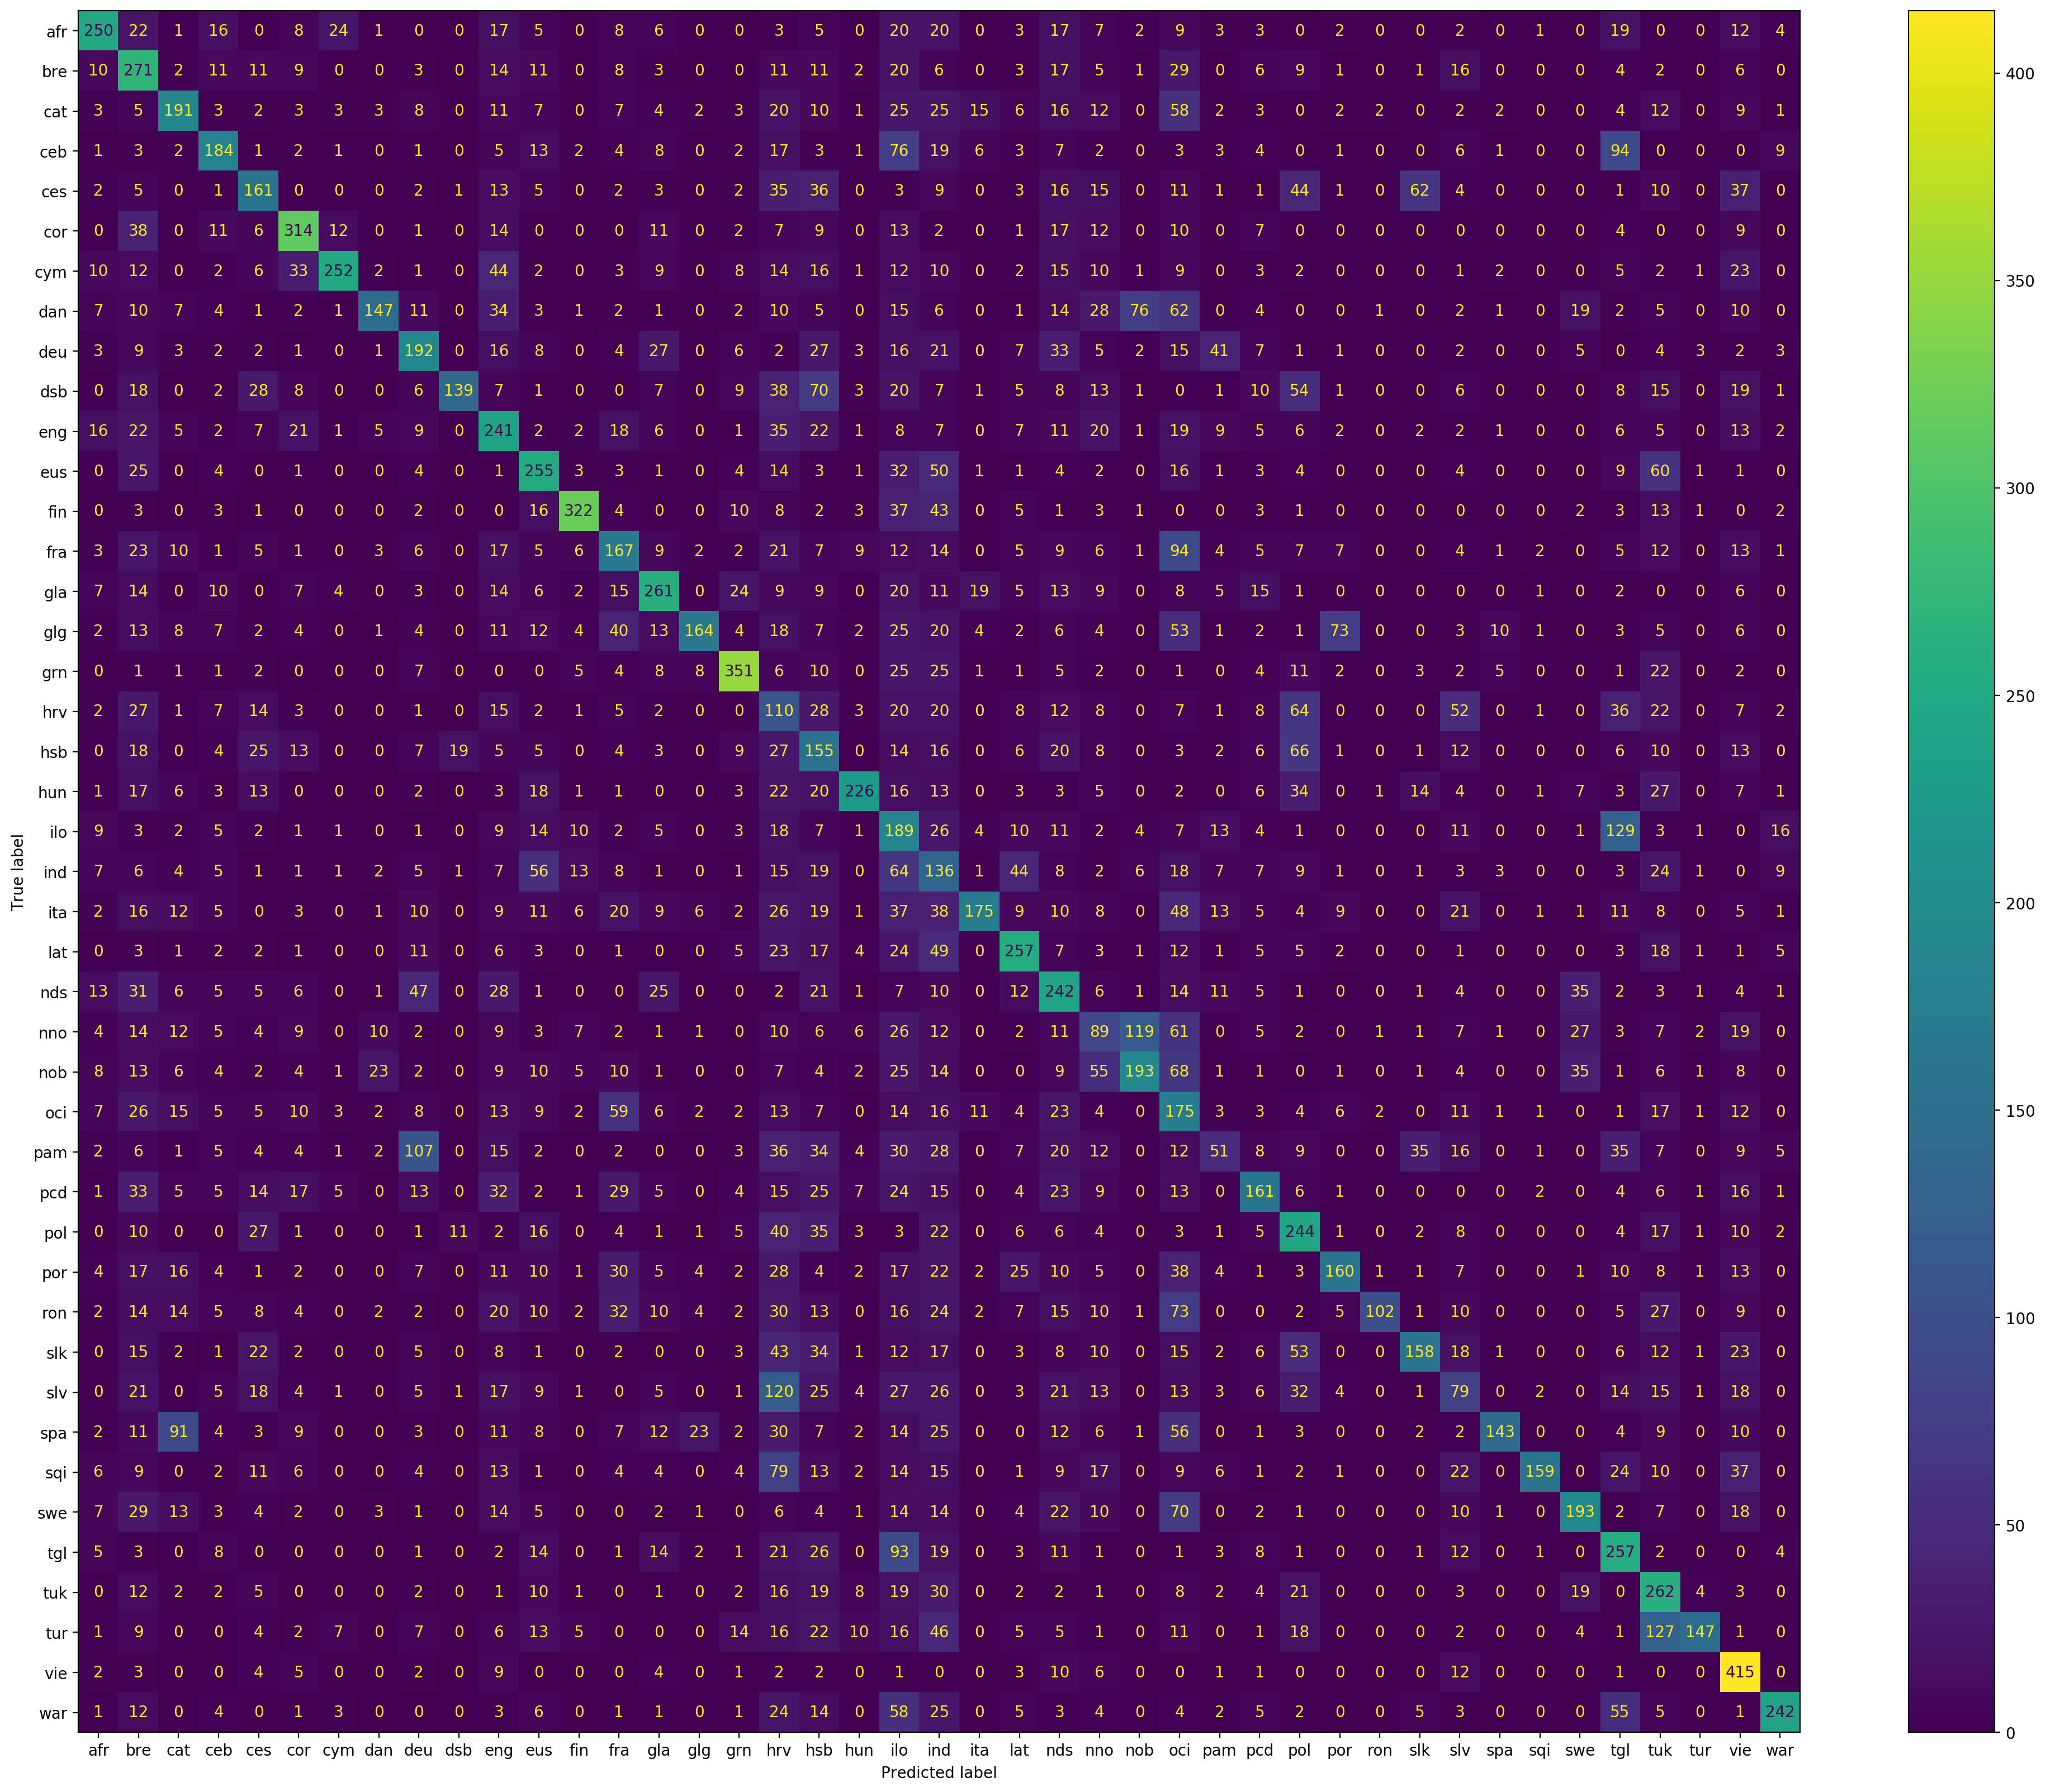

In [8]:
# Confusion Matrix of best C tuned model
fig, ax = plt.subplots(figsize=(25, 20))
labels = data.le.inverse_transform(logreg_fit.classes_)
disp = ConfusionMatrixDisplay.from_predictions(data.y_test, y_pred, labels=logreg_fit.classes_, display_labels=labels, ax=ax)
plt.show()

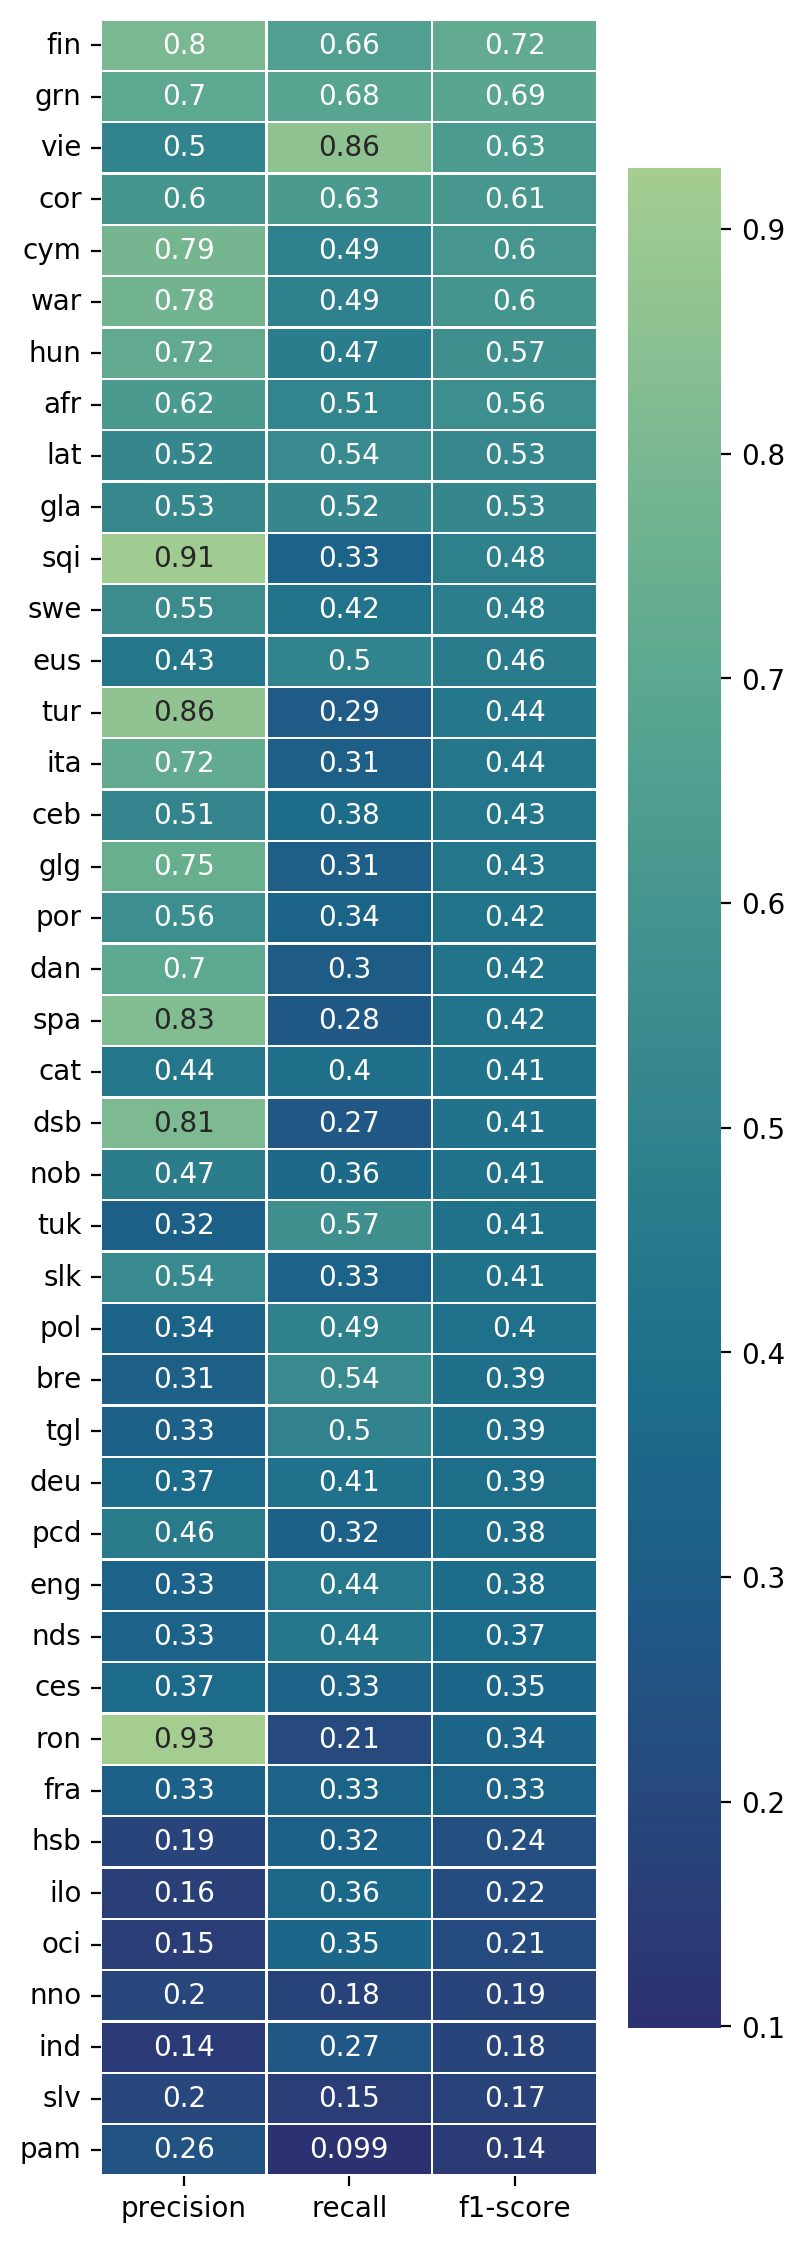

In [9]:
# Classification report of best C tuned model

report = classification_report(data.y_test, y_pred, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose().sort_values("f1-score",ascending=False)
report_df.drop(["macro avg", "weighted avg", "accuracy"], inplace=True)
report_df.drop(["support"], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(4,14)) 
sns.heatmap(pd.DataFrame(report_df).iloc[:-1, :], annot=True, linewidths=.5,ax=ax,cmap="crest_r")